## 可視化（補足）

- 決定木をGraphvizを用いて表示
- 決定木のテキストでの表示
- ヒートマップを用いた混合行列の可視化

### 決定木による species の分類

- sepal_length, sepal_width, petal_length, petal_width を説明変数として species を分類する決定木を作成
- 決定木の深さは max_depth=2

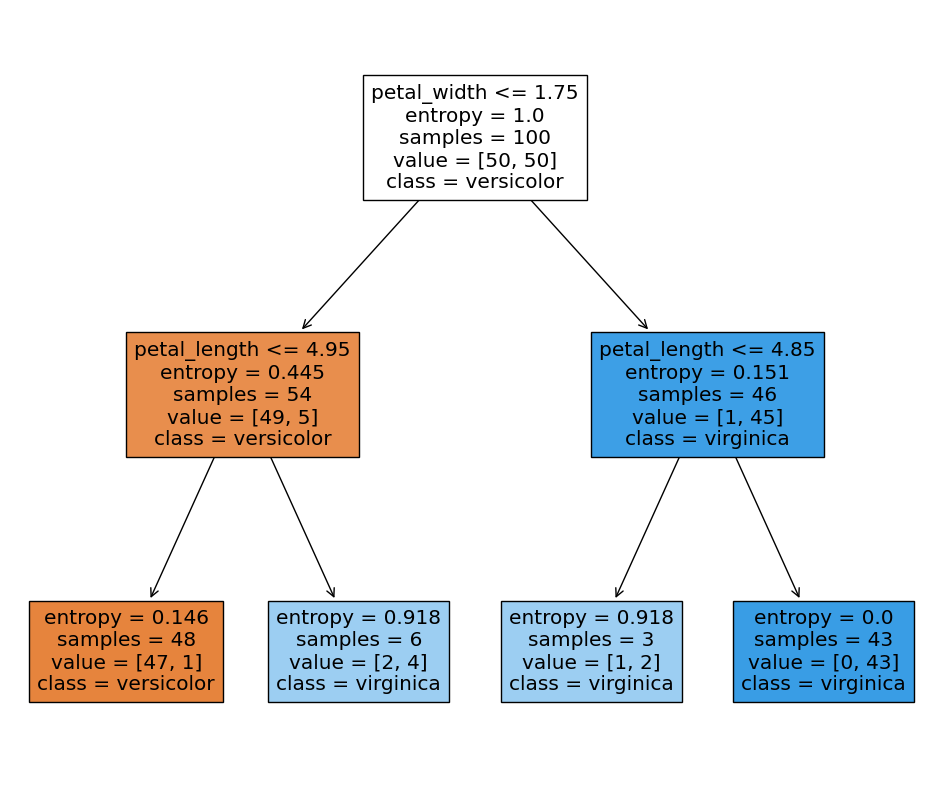

In [1]:
import pandas as pd
import seaborn as sns
iris = sns.load_dataset('iris')

# species が setosa のデータを除去
df = iris.query('species!="setosa"')

# 説明変数、目的変数の作成
X = df.drop(['species'], axis=1)
Y = df.species

# 決定木を作成、正確度を表示
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy', max_depth=2)
model.fit(X, Y)

# 作成した決定木の描画
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
# 描画領域の設定（大きくする）
plt.figure(figsize=(12, 10))
# 決定木
plot_tree(model, feature_names=X.columns, class_names=model.classes_, filled=True)
plt.show()

### 決定木をGraphvizを用いて表示

graphvizパッケージが無いとエラーが出る場合は、端末（ターミナル等）で以下のコマンド
によりインストール：
```
conda install python-graphviz
```

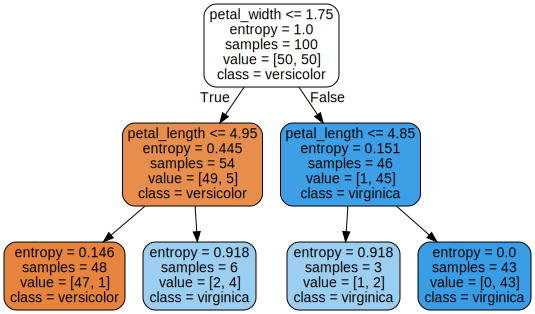

In [3]:
from sklearn.tree import export_graphviz
import graphviz

# 決定木の作成
dot_data = export_graphviz(model, filled=True, rounded=True, out_file=None,
                           feature_names=X.columns, class_names=model.classes_)
# 決定木の描画
graphviz_tree = graphviz.Source(dot_data)
graphviz_tree

In [4]:
# PDFファイルの作成
graphviz_tree.render("iris")

'iris.pdf'

### 決定木のテキストでの表示

In [5]:
from sklearn.tree import export_text

# テキストで作成した決定木をプリント
print(export_text(model, feature_names=X.columns.to_list(), show_weights=True))

|--- petal_width <= 1.75
|   |--- petal_length <= 4.95
|   |   |--- weights: [47.00, 1.00] class: versicolor
|   |--- petal_length >  4.95
|   |   |--- weights: [2.00, 4.00] class: virginica
|--- petal_width >  1.75
|   |--- petal_length <= 4.85
|   |   |--- weights: [1.00, 2.00] class: virginica
|   |--- petal_length >  4.85
|   |   |--- weights: [0.00, 43.00] class: virginica



### ヒートマップを用いた混合行列の可視化

In [6]:
from sklearn.metrics import confusion_matrix

Y_predict = model.predict(X)

# 混合行列の表示
print(confusion_matrix(Y, Y_predict))

[[47  3]
 [ 1 49]]


混合行列
- 1行目1列：実際が0、予測が0 (真陰性：TN)
- 1行目2列：実際が0、予測が1 (偽陽性：FP)
- 2行目1列：実際が1、予測が0 (偽陰性：FN)
- 2行目2列：実際が1、予測が1 (真陽性：TP)

ヒートマップを用いて可視化することで、混合行列の説明が不要な結果を作成

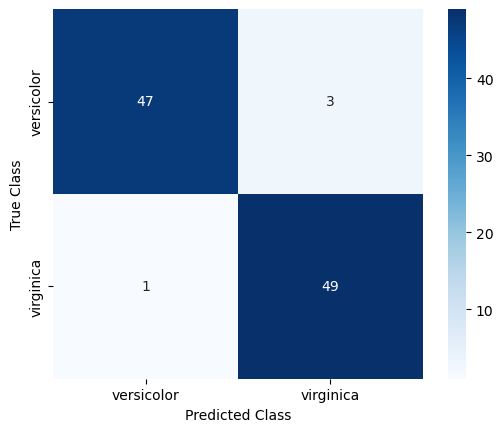

In [7]:
# 混合行列をDataFrameにしてラベルを付ける
df = pd.DataFrame(confusion_matrix(Y, Y_predict), columns=model.classes_, index=model.classes_)

# 混合行列の可視化
sns.heatmap(df, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

### 決定境界

In [8]:
import numpy as np

def plot_decision_boundary(model, X, y):
    """
    決定境界の描画関数
    """
    # 1, 2列目の取得
    x1 = X.iloc[:,0]
    x2 = X.iloc[:,1]

    # 散布図の描画
    sns.scatterplot(x=x1, y=x2, hue=y)

    # 刻み幅の指定
    step = 0.01
    # 描画範囲の拡大幅
    a = 0.5
    # 格子座標の作成
    x1_mesh, x2_mesh = np.meshgrid(np.arange(x1.min() - a, x1.max() + a, step),
                                   np.arange(x2.min() - a, x2.max() + a, step))
    # 格子の座標に対する予測値を計算
    Z = model.predict(pd.DataFrame(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T,
                                   columns=X.columns))
    # contourf: 領域の塗りつぶし
    # - alpha: 透過度
    # - cmap: https://matplotlib.org/stable/tutorials/colors/colormaps.html に記載
    plt.contourf(x1_mesh, x2_mesh, Z.reshape(x1_mesh.shape), alpha=0.3, cmap='coolwarm')
    plt.show()

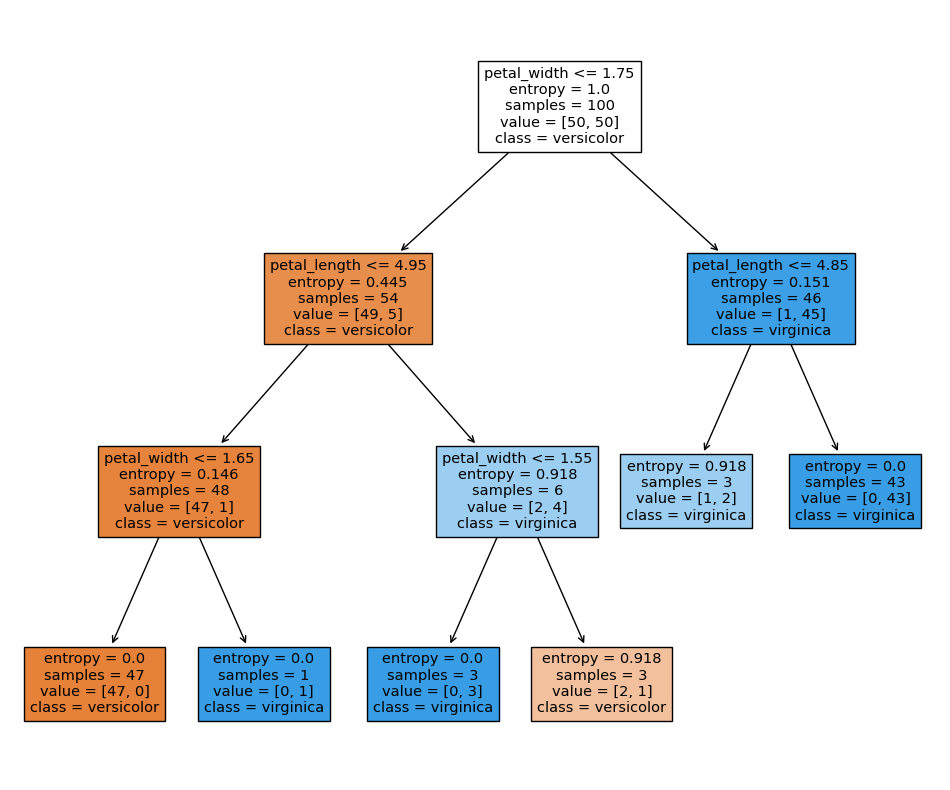

In [9]:
# species が setosa のデータを除去
df = iris.query('species!="setosa"')

# ダミー変数化
df_dummy = pd.get_dummies(data=df, drop_first=True)

# 説明変数、目的変数の作成
# - 決定境界の描画のため、説明変数は2つだけ
X = df_dummy[['petal_width', 'petal_length']]
Y = df_dummy.species_virginica

# 決定木を作成、正確度を表示
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model.fit(X, Y)

# 決定木
plt.figure(figsize=(12, 10))
plot_tree(model, feature_names=X.columns, class_names=['versicolor', 'virginica'], filled=True)
plt.show()

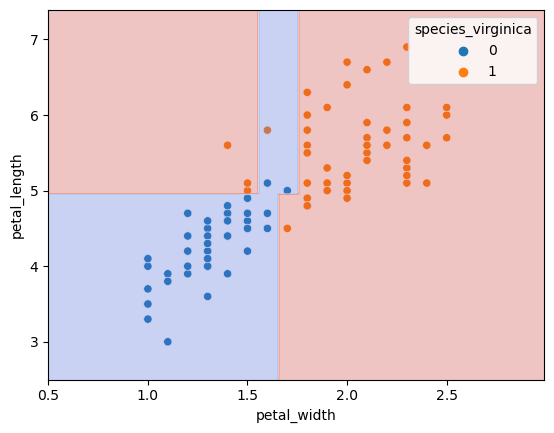

In [10]:
# 決定境界の描画
plot_decision_boundary(model, X, Y)

8_1_decision_tree_iris.ipynb での分割条件を重ねて表示した散布図では、大多数が入る領域に着目しているため、<br>
以下の分割条件を描画している。
- petal_width <= 1.65, petal_length <= 4.95 ... versicolor 47
- petal_width > 1.75, petal_length > 4.85 ... virginica 43

そのため、以下の条件の境界は描画していないことに注意。

- petal_width <= 1.55, petal_length > 4.95

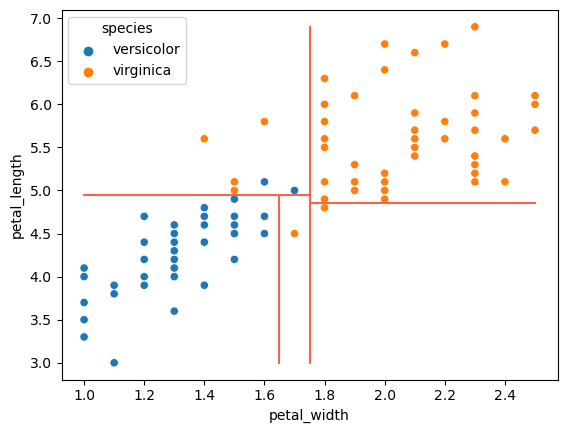

In [11]:
sns.scatterplot(x=df.petal_width, y=df.petal_length, hue=df.species)

petal_length_min = df.petal_length.min()
petal_length_max = df.petal_length.max()
petal_width_min = df.petal_width.min()
petal_width_max = df.petal_width.max()

# １．根ノード：petal_width <= 1.75
x = 1.75
plt.plot([x, x], [petal_length_min, petal_length_max], color='tomato')

# ２．１の左下：petal_length <= 4.95
y = 4.95
plt.plot([petal_width_min, x], [y, y], color='tomato')

# ３．２の左下：petal_width <= 1.65
x = 1.65
plt.plot([x, x], [petal_length_min, y], color='tomato')

# ４．１の右下：petal_length > 4.85
x = 1.75
y = 4.85
plt.plot([x, petal_width_max], [y, y], color='tomato')